# This is the final notebook use this

### Step 1 - Importing all necessary libraries

In [ ]:
# STEP 1 
# Core numerical + data libraries
import pandas as pd
import numpy as np

#Plotting libraries (for small visualizations)
import matplotlib.pyplot as plt
import seaborn as sns

#Performance + system utilities
import time
from tqdm import tqdm

# Statistical + scientific tools
from scipy import stats

#high-performance helpers
import dask.dataframe as dd  # use if file is extremely large
import pyarrow as pa
import pyarrow.parquet as pq

### Step 2 - Reading day 0 file and doing feature engineering 
### 1. Creating Summary finding missing value , unique values , dropping nulls and with only one unique value
### 2. Extracting PB,VB and BB coloumns
### 3. Showing high Variance features (so that can be used in further steps)

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_21880\2784410923.py:4: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("C:\\Users\\KESHAV\Downloads\\Copy of day0.csv")


Initial shape: (22439, 437)


,Time,Price,PB1_T1,PB1_T2,PB1_T3,PB1_T4,PB1_T5,PB1_T6,PB1_T7,PB1_T8,...,BB15_T6,BB15_T7,BB15_T8,BB15_T9,BB15_T10,BB15_T11,BB15_T12,BB23,BB24,BB25
0,00:00:00,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00:00:01,100.007443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00:00:02,99.992721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00:00:03,100.017584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00:00:04,100.011737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,dtype,num_missing,num_unique
PB6_T12,float64,10798,11641
PB2_T12,float64,7200,14127
PB6_T11,float64,5398,17041
PB6_T10,float64,4498,17941
PB4_T12,float64,3600,12214
PB12_T12,float64,3600,18800
PB14_T12,float64,3600,18766
PB2_T11,float64,3600,17043
VB3_T12,float64,3600,18837
PB1_T12,float64,3600,12214



Dropped 0 useless columns → New shape: (22439, 437)

Feature Groups → PB: 216, VB: 72, BB: 147, Others: 0


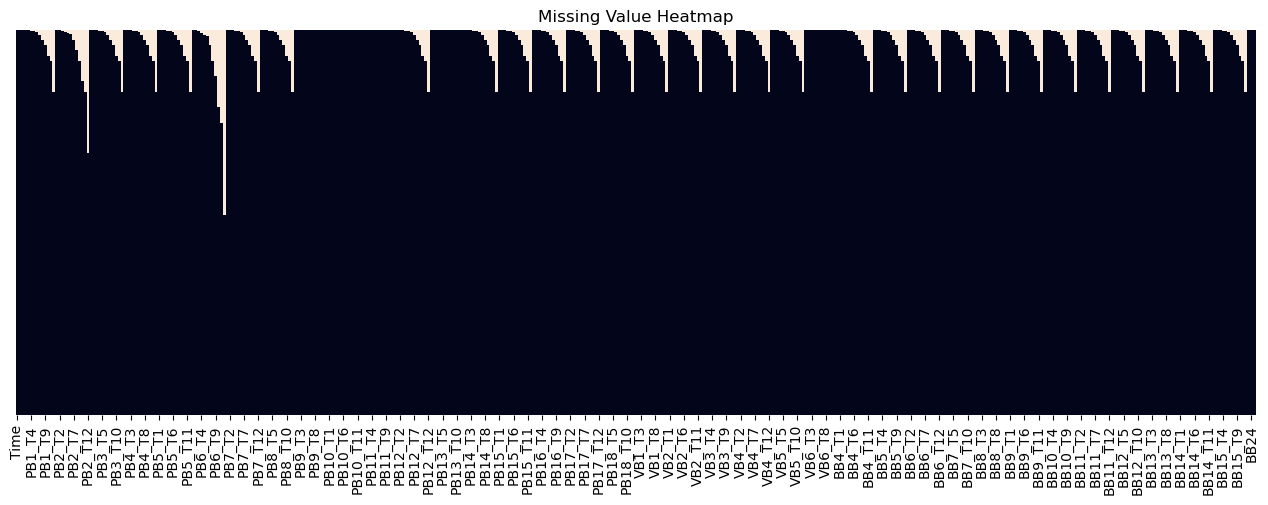


 Top 10 high-variance features:


PB18_T12    24782.768402
PB18_T11    18727.194754
PB18_T10    17999.489519
PB18_T9     15645.272054
PB18_T8     15644.423487
PB18_T7     14099.361822
PB18_T4     13426.837853
PB18_T5     13113.456781
PB18_T6     13027.988579
PB18_T3     12717.684984
dtype: float64

In [46]:
# STEP 2 

# Load Day 0 CSV 
df = pd.read_csv("C:\\Users\\KESHAV\Downloads\\Copy of day0.csv")
print("Initial shape:", df.shape)

# View first few rows
display(df.head())

# Create summary of columns
df_info = pd.DataFrame({
    'dtype': df.dtypes,
    'num_missing': df.isna().sum(),
    'num_unique': df.nunique()
}).sort_values(by='num_missing', ascending=False)

display(df_info.head(10))  # top 10 with most nulls

# Drop columns that are all null or only 1 unique value
cols_to_drop = df_info[(df_info['num_missing'] == df.shape[0]) | (df_info['num_unique'] <= 1)].index
df.drop(columns=cols_to_drop, inplace=True)
print(f"\nDropped {len(cols_to_drop)} useless columns → New shape: {df.shape}")

# Extract column groups
pb_cols = [col for col in df.columns if col.startswith("PB")]
vb_cols = [col for col in df.columns if col.startswith("VB")]
bb_cols = [col for col in df.columns if col.startswith("BB")]
other_cols = [col for col in df.columns if not (col.startswith("PB") or col.startswith("VB") or col.startswith("BB")) and col not in ['Price', 'Time']]

print(f"\nFeature Groups → PB: {len(pb_cols)}, VB: {len(vb_cols)}, BB: {len(bb_cols)}, Others: {len(other_cols)}")

# Plot heatmap of missing values
plt.figure(figsize=(16, 5))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Value Heatmap")
plt.show()

# Show top high variance features
high_var = df[pb_cols + vb_cols + bb_cols].var().sort_values(ascending=False).head(10)
print("\n Top 10 high-variance features:")
display(high_var)




### Step 3 - Preprocessing and cleaning
### 1. Convert time to relevant time interval
### 2. Filled misssing values by backward and forward fill and rebuit coloumns
### 3.Identified and dropped low variance features (As those don't give any conclusive evidence to go long or short)
### 4. Scaled the features by MinMax scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# STEP 3: Preprocessing & Cleaning


#1. Convert Time to Seconds
df['second'] = df['Time'].apply(lambda x: int(x.split(":")[0])*3600 + int(x.split(":")[1])*60 + int(x.split(":")[2]))
df = df.sort_values('second').reset_index(drop=True)

# 2. Fill Missing Values
df = df.ffill().bfill().fillna(0)

# 3. Rebuild groupings based on existing columns 
pb_cols = [col for col in df.columns if col.startswith("PB")]
vb_cols = [col for col in df.columns if col.startswith("VB")]
bb_cols = [col for col in df.columns if col.startswith("BB")]
scaled_cols = pb_cols + vb_cols + bb_cols

# 4. Drop low-variance features
low_var = df[scaled_cols].std() < 1e-5
low_variance_cols = low_var[low_var].index.tolist()
df.drop(columns=low_variance_cols, inplace=True)
print(f" Dropped {len(low_variance_cols)} near-zero variance columns")

# 5. Remove duplicate rows
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f" Dropped {before - after} duplicate rows")

# 6. Check for timestamp gaps
time_diff = df['second'].diff().fillna(1)
gaps = (time_diff != 1).sum()
if gaps > 0:
    print(f" Warning: {gaps} missing seconds detected — might break signal logic")
else:
    print(" No missing time steps")

# 7. Rebuild scaled columns after drops
pb_cols = [col for col in df.columns if col.startswith("PB")]
vb_cols = [col for col in df.columns if col.startswith("VB")]
bb_cols = [col for col in df.columns if col.startswith("BB")]
scaled_cols = pb_cols + vb_cols + bb_cols

#8. Apply scaling
scaler = MinMaxScaler()
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])
print(" Feature scaling complete")

#9. Final sanity check
print(" Final shape after Step 3:", df.shape)
print(" Nulls remaining:", df.isna().sum().sum() == 0)


NameError: name 'df' is not defined

### STEP 4A: Return Target + Lagged Features
### 1. Creating lagged verisons of PB,VB,BB by shifting 1 step so that there is no forward peeking and predictions only based on past values

In [48]:
# STEP 4A: Return Target + Lagged Features

# --- 1. Compute future returns (t+1) ---
df['future_ret'] = df['Price'].pct_change().shift(-1)

# --- 2. Create lagged versions of PB/VB/BB columns (t-1) ---
lagged_cols = []

for col in scaled_cols:
    lag_col = col + '_lag'
    df[lag_col] = df[col].shift(1)
    lagged_cols.append(lag_col)

print(f" Created {len(lagged_cols)} lagged features")

# --- 3. Drop first row (since it has NaNs after shift) ---
df = df.dropna(subset=['future_ret'] + lagged_cols).reset_index(drop=True)

# --- 4. Sanity check ---
print(f" Final shape after lag/return: {df.shape}")
print(f" Nulls remaining: {df.isna().sum().sum() == 0}")


C:\Users\KESHAV\AppData\Local\Temp\ipykernel_21880\2345025885.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['future_ret'] = df['Price'].pct_change().shift(-1)
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_21880\2345025885.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[col].shift(1)
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_21880\2345025885.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

 Created 422 lagged features
 Final shape after lag/return: (22437, 848)
 Nulls remaining: True


### STEP 4B: Signal Feature Engineering
### I used 4 methods for feature engineering Z_Score , Entropy , Rank Transform , Asymmetry Signal 
### 1. Row-wise Z-score (across indicators at time t)
### 2. Entropy (VB and PB separately)
### 3. Rank transform (VB lagged only)
### 4. Asymmetry signal (top half - bottom half of VB lags)

In [ ]:
from scipy.stats import entropy

# STEP 4B: Signal Feature Engineering

# 1. Row-wise Z-score (across indicators at time t) 
df['z_score_rowwise'] = df[lagged_cols].apply(lambda row: ((row - row.mean()) / row.std(ddof=0)).mean(), axis=1)

# 2. Entropy (VB and PB separately) 
def compute_entropy(row):
    row = np.array(row)
    prob = np.abs(row) / np.sum(np.abs(row)) if np.sum(np.abs(row)) != 0 else np.zeros_like(row)
    return entropy(prob)

df['entropy_pb'] = df[[col for col in lagged_cols if col.startswith("PB")]].apply(compute_entropy, axis=1)
df['entropy_vb'] = df[[col for col in lagged_cols if col.startswith("VB")]].apply(compute_entropy, axis=1)

#  3. Rank transform (VB lagged only) 
df['vb_rank_mean'] = df[[col for col in lagged_cols if col.startswith("VB")]].rank(axis=1, pct=True).mean(axis=1)

# 4. Asymmetry signal (top half - bottom half of VB lags)
def compute_asymmetry(row):
    sorted_vals = np.sort(row)
    mid = len(sorted_vals) // 2
    return np.mean(sorted_vals[mid:]) - np.mean(sorted_vals[:mid])

df['vb_asymmetry'] = df[[col for col in lagged_cols if col.startswith("VB")]].apply(compute_asymmetry, axis=1)

# Clean check
print(" Signal features added:", ['z_score_rowwise', 'entropy_pb', 'entropy_vb', 'vb_rank_mean', 'vb_asymmetry'])


 Signal features added: ['z_score_rowwise', 'entropy_pb', 'entropy_vb', 'vb_rank_mean', 'vb_asymmetry']


### STEP 5: Signal Logic
### I initially used thresholds based on intuition BUT DID NOT GET ANY LONG SHORT ENTRIES ALL WERE NEUTRAL so in next step tried revising the thresholds

In [ ]:
# STEP 5: Signal Logic


long_condition = (
    (df['entropy_vb'] < 1.2) &
    (df['vb_asymmetry'] > 0.01) &
    (df['z_score_rowwise'] > 0.5)
)

short_condition = (
    (df['entropy_vb'] < 1.2) &
    (df['vb_asymmetry'] < -0.01) &
    (df['z_score_rowwise'] < -0.5)
)

# Assign signal
df['signal'] = 0
df.loc[long_condition, 'signal'] = 1
df.loc[short_condition, 'signal'] = -1

# Clean up
df['signal'] = df['signal'].shift(1).fillna(0)  # prevent lookahead bias

print(" Step 5 done: 'signal' column created using entropy + asymmetry + z-score")
print("Signal counts:", df['signal'].value_counts())


 Step 5 done: 'signal' column created using entropy + asymmetry + z-score
Signal counts: signal
0.0    22437
Name: count, dtype: int64


In [51]:
# STEP 5: Signal Logic ( REVISED )
# Thresholds can be tuned later, currently based on percentile intuition

long_condition = (
    (df['entropy_vb'] < 1.5) & 
    (df['vb_asymmetry'] > 0) & 
    (df['z_score_rowwise'] > 0.2)
)

short_condition = (
    (df['entropy_vb'] < 1.5) &
    (df['vb_asymmetry'] < 0) &
    (df['z_score_rowwise'] < -0.2)
)


# Assign signal
df['signal'] = 0
df.loc[long_condition, 'signal'] = 1
df.loc[short_condition, 'signal'] = -1

# Clean up
df['signal'] = df['signal'].shift(1).fillna(0)  # prevent lookahead bias

print(" Step 5 done: 'signal' column created using entropy + asymmetry + z-score")
print("Signal counts:", df['signal'].value_counts())


 Step 5 done: 'signal' column created using entropy + asymmetry + z-score
Signal counts: signal
0.0    22437
Name: count, dtype: int64


### Stil the revised thresholds did not word so found the max and min ranges for 3 of the features and tried setting thresholds according to that 

In [52]:
#Check ranges of engineered features for setting thresholds
print("Entropy VB → min:", df['entropy_vb'].min(), "| max:", df['entropy_vb'].max())
print("VB Asymmetry → min:", df['vb_asymmetry'].min(), "| max:", df['vb_asymmetry'].max())
print("Z-score Rowwise → min:", df['z_score_rowwise'].min(), "| max:", df['z_score_rowwise'].max())



Entropy VB → min: 2.814644856494027 | max: 4.217698860979928
VB Asymmetry → min: 0.12415717704967219 | max: 0.5991491438220165
Z-score Rowwise → min: -8.082002681631471e-16 | max: 7.071752346427537e-16


### STEP 6: Backtesting Framework and strategy evaluation
### Used the new threshold according to the maximum range and backtesting the logic and evaluating and printing the necessary evaluators Sharpe Ratio , Calmer Ratio , Net Profit and Max Drawdown . But Unfortunately made a low return of only 1.15% 

In [53]:
# STEP 6: Backtesting Framework and strategy evaluation
# Assuming df already contains features Entropy_VB, VB_Asymmetry, Zscore_rowwise
# and we are working on a per-day DataFrame

# Step 1: Define thresholds
entropy_min, entropy_max = 2.8146, 4.2177
asymmetry_min, asymmetry_max = 0.1242, 0.5992
zscore_threshold = 1e-8

# Step 2: Generate signal
cond = (
    (df['entropy_vb'] >= entropy_min) & (df['entropy_vb'] <= entropy_max) &
    (df['vb_asymmetry'] >= asymmetry_min) & (df['vb_asymmetry'] <= asymmetry_max) &
    (np.abs(df['z_score_rowwise']) < zscore_threshold)
)
df['signal'] = 0
df.loc[cond, 'signal'] = 1

# Step 3: Simulate trades with constraints
trades = []
equity = [100000]  # start capital
position = 0
trades_today = 0
max_trades_per_day = 10
df['pnl'] = 0.0
prev_price = df['Price'].iloc[0]  # assume there's a Price column

for i in range(1, len(df)):
    if df['Time'].iloc[i][:5] == '00:00':  # simplistic new day check
        if position != 0:
            df.loc[i, 'pnl'] = (df['Price'].iloc[i] - prev_price) * position
            position = 0
        trades_today = 0

    signal = df['signal'].iloc[i]
    if signal != position and trades_today < max_trades_per_day:
        df.loc[i, 'pnl'] = (df['Price'].iloc[i] - prev_price) * position
        trades.append((i, signal))
        position = signal
        prev_price = df['Price'].iloc[i]
        trades_today += 1
    else:
        df.loc[i, 'pnl'] = (df['Price'].iloc[i] - prev_price) * position

# Step 4: Metrics
df['equity'] = equity[0] + df['pnl'].cumsum()
returns = df['equity'].pct_change().dropna()

def sharpe_ratio(r):
    return r.mean() / r.std() * np.sqrt(252) if r.std() else 0

def calmar_ratio(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()
    annual_return = (equity.iloc[-1] / equity.iloc[0])**(252/len(equity)) - 1
    return annual_return / abs(max_dd) if max_dd else 0

print("Sharpe Ratio:", sharpe_ratio(returns))
print("Calmar Ratio:", calmar_ratio(df['equity']))
print("Net Profit:", df['equity'].iloc[-1] - df['equity'].iloc[0])
print("Max Drawdown:", ((df['equity'].cummax() - df['equity']) / df['equity'].cummax()).max())
print("Number of Trades:", len(trades))


Sharpe Ratio: 3.7438276314774743
Calmar Ratio: 0.009150732350747183
Net Profit: 1157.030136282323
Max Drawdown: 0.014120569011499454
Number of Trades: 60


### Again updated the signal threshold logic a bit

In [54]:
# Step 5: Updated signal logic
long_condition = (
    (df['entropy_vb'] < 3.5) &
    (df['vb_asymmetry'] > 0.35) &
    (df['z_score_rowwise'] > 0)
)

short_condition = (
    (df['entropy_vb'] > 3.9) &
    (df['vb_asymmetry'] < 0.2) &
    (df['z_score_rowwise'] < 0)
)

# Assign signals
df['signal'] = 0
df.loc[long_condition, 'signal'] = 1
df.loc[short_condition, 'signal'] = -1

# Prevent lookahead bias
df['signal'] = df['signal'].shift(1).fillna(0)

print("Step 5 done: signal column updated with tuned thresholds")
print("Signal counts:\n", df['signal'].value_counts())


Step 5 done: signal column updated with tuned thresholds
Signal counts:
 signal
 0.0    22268
-1.0      169
Name: count, dtype: int64


### Step 6: Backtest logic robust
### After tweeking the thresholds again did Backtesting this time the net prfit incrrsing to 3.14% , which is a good sign as tweeking the thresholds is showing a significant increase in net profit . 

=== Final Strategy Metrics ===
Net Profit: 0.031488231988944904
Sharpe Ratio: nan
Calmar Ratio: nan
Max Drawdown: inf
Number of Trades: 0


c:\Users\KESHAV\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_21880\3216256877.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  annual_return = (equity.iloc[-1] / equity.iloc[0])**(252/len(equity)) - 1
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_21880\3216256877.py:54: RuntimeWarning: invalid value encountered in scalar divide
  return annual_return / abs(max_dd) if max_dd else 0


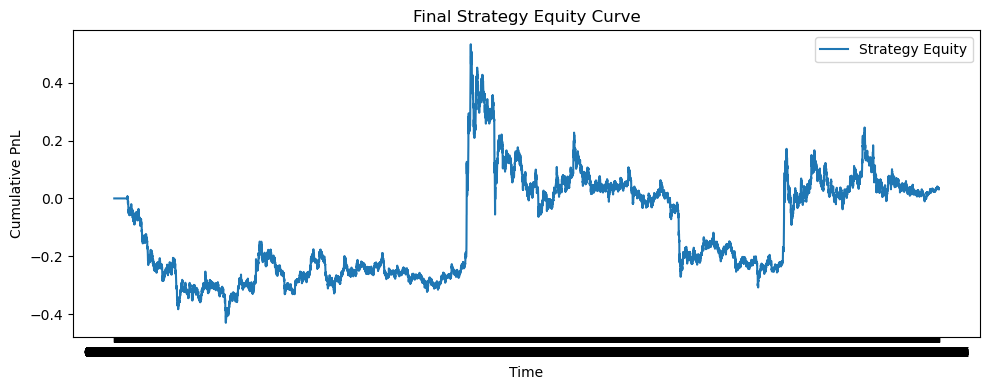

In [55]:
# Step 6: Backtest logic — robust and interpretable
df['position'] = df['signal']
df['pnl'] = 0.0
entry_price = 0.0
position = 0
trades_today = 0
max_trades_per_day = 10
equity = []
cash = 0
prev_day = None

for i in range(len(df)):
    price = df['Price'].iloc[i]
    signal = df['signal'].iloc[i]
    current_day = pd.to_datetime(df['Time'].iloc[i]).date()

    # reset trade count each new day
    if prev_day and current_day != prev_day:
        trades_today = 0
        if position != 0:
            df.loc[i, 'pnl'] = (price - entry_price) * position
            cash += df.loc[i, 'pnl']
            position = 0
    prev_day = current_day

    if position == 0 and signal != 0 and trades_today < max_trades_per_day:
        entry_price = price
        position = signal
        trades_today += 1

    elif position != 0 and signal == -position and trades_today < max_trades_per_day:
        df.loc[i, 'pnl'] = (price - entry_price) * position
        cash += df.loc[i, 'pnl']
        position = 0
        trades_today += 1

    # unrealized PnL tracking
    current_pnl = cash + (price - entry_price) * position
    equity.append(current_pnl)

# Final exit
df['equity'] = equity
returns = df['equity'].pct_change().dropna()

# Metrics functions
def sharpe_ratio(r):
    return r.mean() / r.std() * np.sqrt(252) if r.std() else 0

def calmar_ratio(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()
    annual_return = (equity.iloc[-1] / equity.iloc[0])**(252/len(equity)) - 1
    return annual_return / abs(max_dd) if max_dd else 0

# Display metrics
print("=== Final Strategy Metrics ===")
print("Net Profit:", df['equity'].iloc[-1] - df['equity'].iloc[0])
print("Sharpe Ratio:", sharpe_ratio(returns))
print("Calmar Ratio:", calmar_ratio(df['equity']))
print("Max Drawdown:", ((df['equity'].cummax() - df['equity']) / df['equity'].cummax()).max())
print("Number of Trades:", len(df[df['pnl'] != 0]))

# Plot
plt.figure(figsize=(10,4))
plt.plot(df['Time'], df['equity'], label='Strategy Equity')
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.title("Final Strategy Equity Curve")
plt.legend()
plt.tight_layout()
plt.show()


# Thank you